# Start of actual analysis

Previous Paper: https://pubmed.ncbi.nlm.nih.gov/30334800/ 

used similar dataset, LSTM + 1d-AX + softmax

1d-AX: kinda like windowed mean in A2

In [1]:
import biosig
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz 


data_path = './BCICIV_2b_gdf/'#the folder where all raw data files live
train_portion = 0.7 #the portion of training data among all the raw data files

# from the data description document
event_start = 4 #the start time point (sec) of imagery for each trial
event_end = 7 #the end time point (sec) of imagery for each trial
bsl_start = 0 #the start time point (sec) of baseline for each trial
bsl_end = 2 #the end time point (sec) of baseline for each trial

files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
files = [f for f in files if f[-5]=='T']
# for testing purposes only
train_files = files[:5]

# train_files = train_files[:int(len(files)*train_portion)]

## Define functions

In [2]:
def time_ind_conversion(sr, t):
    """
    Convert time in second to the index in the signal array
    """
    return int(np.round(sr*t))


# from A1
def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y
    
    
def populate_data(files, event_start, event_end, bsl_start, bsl_end):
    """
    populate and pre-process (without filtering) data for training the model
    
    input:
        files: list of file paths to the raw data files
        event_start: the start time point (sec) of imagery for each trial
        event_end: the end time point (sec) of imagery for each trial
        bsl_start: the start time point (sec) of baseline for each trial
        bsl_end: the end time point (sec) of baseline for each trial
        
    output:
        data: list of eeg signal segments for each imagery 
        label: list of labels for each segment
    
    """
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            #calculate baseline and trial mean
            t_bsl_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
            t_bsl_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
            bsl_sig = all_data[:3, t_bsl_start:t_bsl_end]
            bsl = np.nanmean(bsl_sig, 1)
            trial_mean = np.nanmean(seg, 1)
            #preprocess the data by subtract baseline and the trial mean
            seg_after = (seg.T - bsl - trial_mean).T
            
            data.append(seg_after)
            labels.append(mi_events.Description[j])
    return data, labels

def populate_filt_data(files, event_start, event_end, bsl_start, bsl_end, lowcut=0.1, highcut=30):
    """
    populate and pre-process data for training the model
    
    "It is noted in the literature that while performing any motor imagery tasks, 
    two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) 
    bands are actively involved."
    
    input:
        files: list of file paths to the raw data files
        event_start: the start time point (sec) of imagery for each trial
        event_end: the end time point (sec) of imagery for each trial
        bsl_start: the start time point (sec) of baseline for each trial
        bsl_end: the end time point (sec) of baseline for each trial
        lowcut: lower end of the bandpass filter, default=0.1Hz
        highcut: higher end of the bandpass filter, default=30Hz
        
    output:
        data: list of eeg signal segments for each imagery 
        label: list of labels for each segment
    
    """
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            #calculate baseline and trial mean
            t_bsl_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
            t_bsl_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
            bsl_sig = all_data[:3, t_bsl_start:t_bsl_end]
            bsl = np.nanmean(bsl_sig, 1)
            trial_mean = np.nanmean(seg, 1)
            #preprocess the data by subtract baseline and the trial mean
            seg_after = butter_bandpass_filter((seg.T - bsl - trial_mean).T, lowcut=lowcut, highcut=highcut, fs=sr)
            
            data.append(seg_after)
            labels.append(mi_events.Description[j])
    return data, labels

def reshape_data(data, label):
    x = np.dstack(data)
    x = x.reshape(x.shape[2], x.shape[1], x.shape[0])
    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(label)
    return x, y


### Look at one example (raw data)

In [6]:
train_data, train_label = populate_data(train_files, event_start, event_end, bsl_start, bsl_end)

In [7]:
i = train_files[0]
HDR = json.loads(biosig.header(i))
sr  = HDR['Samplingrate']
events = pd.json_normalize(HDR['EVENT'])
mi_events = events[events.Description.apply(lambda x: 'class' in x)]
all_data = biosig.data(i).T
j = mi_events.index[0]
seg = train_data[0]


bsl_start = 0
bsl_end = 2
t_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
t_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
bsl_sig = all_data[:3, t_start:t_end]
bsl = np.nanmean(bsl_sig, 1)
trial_mean = np.nanmean(seg, 1)
seg_after = (seg.T - bsl - trial_mean).T

In [8]:
bsl

array([-0.79705766,  2.11448107, -1.65248934])

In [9]:
trial_mean

array([ 0.79705766, -2.11448107,  1.65248934])

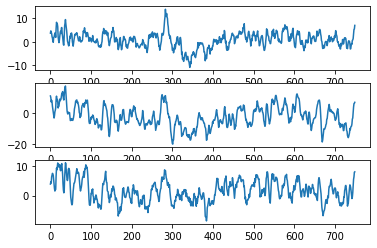

In [10]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(seg_after[i, :])

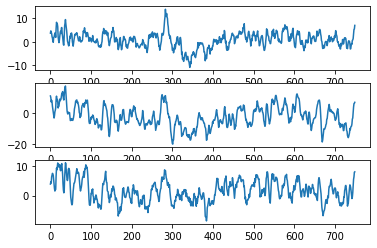

In [11]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(seg[i, :])

## Build the model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SimpleRNN, LSTM, GRU
from keras.optimizers import SGD, Nadam, Adam, RMSprop
from keras.callbacks import TensorBoard
from keras.utils import np_utils
import scipy.io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [15]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(750, 3)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 750, 20)           1920      
_________________________________________________________________
lstm_1 (LSTM)                (None, 750, 10)           1240      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 2)                 12        
Total params: 3,492
Trainable params: 3,492
Non-trainable params: 0
_________________________________________________________________


## Train model on raw data

In [16]:
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)
train_x.shape, test_x.shape

((576, 750, 3), (144, 750, 3))

In [17]:
train_y.shape, test_y.shape

((576, 1), (144, 1))

In [18]:
optim = Nadam(lr=0.001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.fit(train_x, train_y, epochs=20, batch_size=100)

Epoch 1/20
6/6 [==============================] - 8s 600ms/step - loss: 0.7039 - accuracy: 0.4724
Epoch 2/20
6/6 [==============================] - 4s 600ms/step - loss: 0.7023 - accuracy: 0.4348
Epoch 3/20
6/6 [==============================] - 4s 625ms/step - loss: 0.6952 - accuracy: 0.4929
Epoch 4/20
6/6 [==============================] - 4s 577ms/step - loss: 0.6938 - accuracy: 0.4981
Epoch 5/20
6/6 [==============================] - 3s 538ms/step - loss: 0.6889 - accuracy: 0.5476
Epoch 6/20
6/6 [==============================] - 3s 540ms/step - loss: 0.6920 - accuracy: 0.5185
Epoch 7/20
6/6 [==============================] - 3s 538ms/step - loss: 0.6894 - accuracy: 0.5630
Epoch 8/20
6/6 [==============================] - 3s 541ms/step - loss: 0.6862 - accuracy: 0.5816
Epoch 9/20
6/6 [==============================] - 3s 545ms/step - loss: 0.6855 - accuracy: 0.5685
Epoch 10/20
6/6 [==============================] - 3s 569ms/step - loss: 0.6821 - accuracy: 0.5853
Epoch 11/20
6/6 [==

In [19]:
cond1_ind = np.where(train_y==[0])[0]
cond2_ind = np.where(train_y==[1])[0]
cond1_avg = np.mean(train_x[cond1_ind, :,:], axis=0)
cond2_avg = np.mean(train_x[cond2_ind, :,:], axis=0)

In [20]:
cond1_avg.shape

(750, 3)

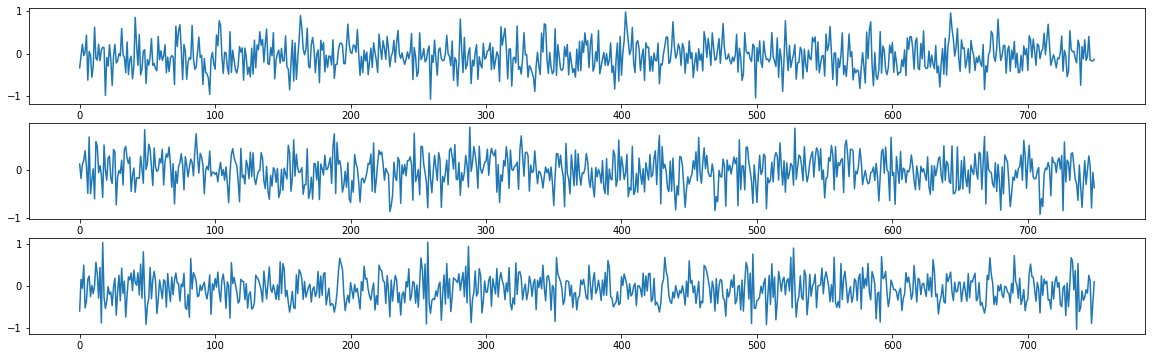

In [21]:
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond1_avg[:,i])

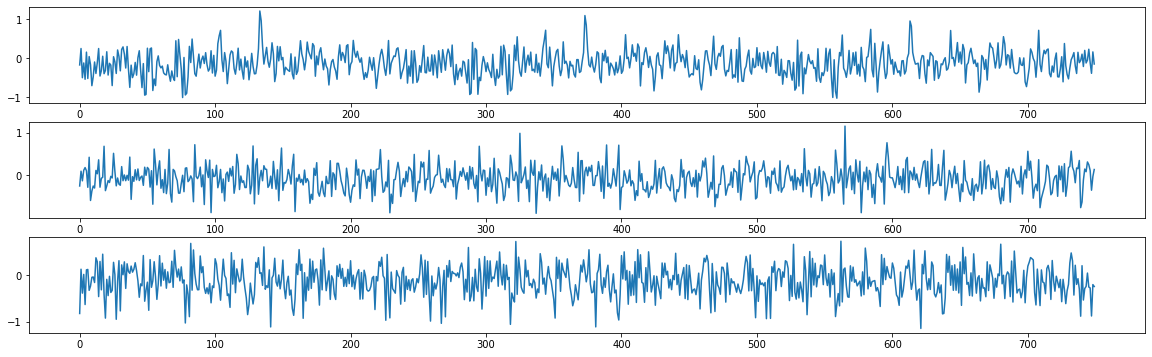

In [22]:
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond2_avg[:,i])

## Train model on filtered data

In [23]:
train_data_filt, train_label_filt = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data_filt, label_filt = reshape_data(train_data_filt, train_label_filt)
train_x_filt, test_x_filt, train_y_filt, test_y_filt = train_test_split(data_filt, label_filt, test_size=0.2, random_state=42)

In [24]:
model.fit(train_x_filt, train_y_filt, epochs=20, batch_size=100)

Epoch 1/20
6/6 [==============================] - 3s 525ms/step - loss: 0.6895 - accuracy: 0.5486
Epoch 2/20
6/6 [==============================] - 3s 528ms/step - loss: 0.6865 - accuracy: 0.5417
Epoch 3/20
6/6 [==============================] - 3s 532ms/step - loss: 0.6842 - accuracy: 0.5469
Epoch 4/20
6/6 [==============================] - 4s 594ms/step - loss: 0.6798 - accuracy: 0.5642
Epoch 5/20
6/6 [==============================] - 4s 630ms/step - loss: 0.6768 - accuracy: 0.5712
Epoch 6/20
6/6 [==============================] - 4s 589ms/step - loss: 0.6730 - accuracy: 0.5729
Epoch 7/20
6/6 [==============================] - 4s 638ms/step - loss: 0.6693 - accuracy: 0.5920
Epoch 8/20
6/6 [==============================] - 3s 538ms/step - loss: 0.6649 - accuracy: 0.5938
Epoch 9/20
6/6 [==============================] - 3s 541ms/step - loss: 0.6580 - accuracy: 0.5972
Epoch 10/20
6/6 [==============================] - 3s 531ms/step - loss: 0.6497 - accuracy: 0.6163
Epoch 11/20
6/6 [==

In [25]:
cond1_ind_filt = np.where(train_y_filt==[0])[0]
cond2_ind_filt = np.where(train_y_filt==[1])[0]
cond1_avg_filt = np.mean(train_x_filt[cond1_ind_filt, :,:], axis=0)
cond2_avg_filt = np.mean(train_x_filt[cond2_ind_filt, :,:], axis=0)

In [26]:
len(cond1_ind_filt), len(cond2_ind_filt)

(289, 287)

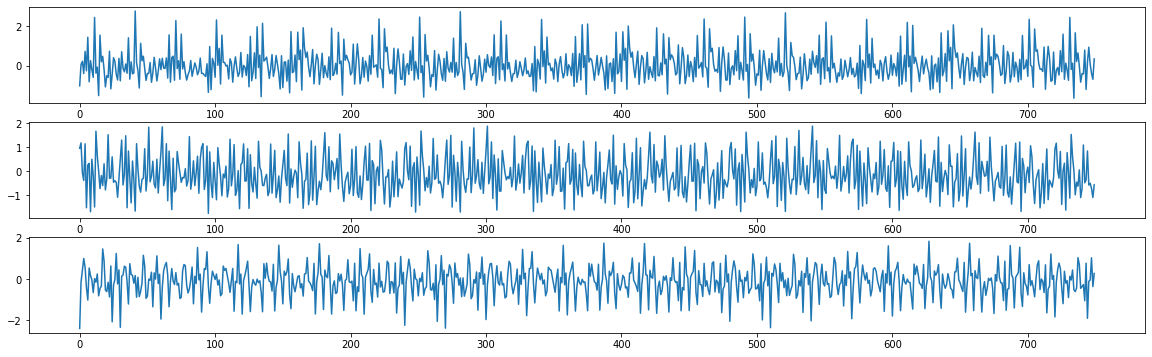

In [27]:
# why blank spot? Use csp?
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond1_avg_filt[:,i])

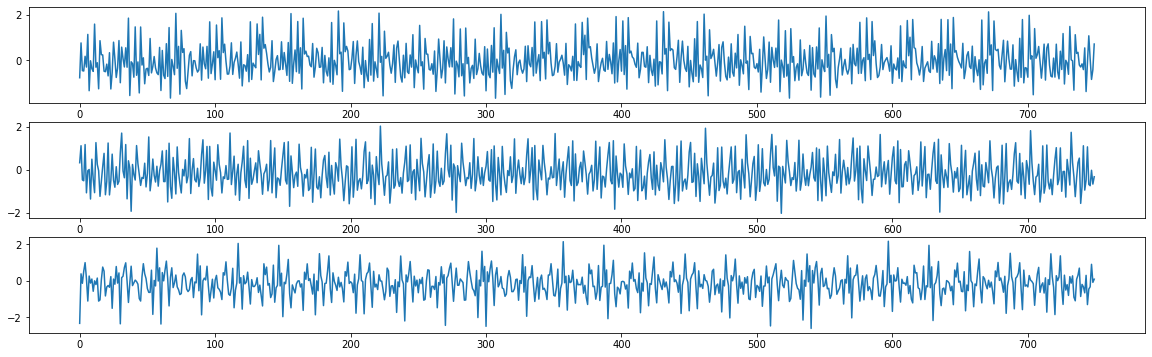

In [28]:
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond2_avg_filt[:,i])

# Questions for check point 1

1. Remove EOG artifact: Needed? How?
2. Another tangent: feasible to include EOG information in the classification? Individual variation too high?
3. CSP? Restricted by the number of channels?
4. Difference not distinct between averaged signals
5. Amplitude much smaller after averaging, also noisier


# Testing garbage place

In [ ]:
import biosig
import json
import numpy as np


In [ ]:
HDR=json.loads(biosig.header('BCICIV_2b_gdf/B0101T.gdf'))

In [ ]:
HDR.keys()

In [ ]:
sr  = HDR['Samplingrate']
sr

In [ ]:
HDR['CHANNEL']

In [ ]:
import pandas as pd
events = pd.json_normalize(HDR['EVENT'])
events[:10]

In [ ]:
data=biosig.data('BCICIV_2b_gdf/B0101T.gdf').T
data.shape

In [ ]:
import numpy as np
def time_ind_conversion(sr, t):
    return int(np.round(sr*t))

In [ ]:
t_start = time_ind_conversion(sr, events.POS[8]+4)
t_end = time_ind_conversion(sr, events.POS[8]+7)
left_test = data[:,t_start:t_end]
left_test.shape

In [ ]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_test[i, :])
    

In [ ]:
t_start = time_ind_conversion(sr, events.POS[10]+4)
t_end = time_ind_conversion(sr, events.POS[10]+7)
right_test = data[:,t_start:t_end]
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_test[i, :])

## High pass approach

It is noted in the literature that while performing any motor imagery tasks, two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) bands are actively involved.

In [ ]:
# from A1
from scipy.signal import butter, sosfiltfilt, sosfreqz 

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

In [ ]:
lowcut = 0.1
highcut= 30
left_filtered = butter_bandpass_filter(left_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_filtered[i,:])

In [ ]:
right_filtered = butter_bandpass_filter(right_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_filtered[i,:])

## FFT approach

In [ ]:
from scipy.fft import fft, fftfreq
N = left_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(left_test[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()


In [ ]:
N = right_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(right_test[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()
